In [1]:
import myutil as mu
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset  # 텐서데이터셋
from torch.utils.data import DataLoader  # 데이터로더
from torch.utils.data import Dataset
import matplotlib.pyplot as plt  # 맷플롯립사용
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random



--- 
 - 소프트맥스 회귀로 MNIST 데이터 분류하기 
   - 이번 챕터에서는 MNIST 데이터에 대해서 이해하고, 
   - 파이토치(PyTorch)로 소프트맥스 회귀를 구현하여 MNIST 데이터를 분류하는 실습을 진행해봅시다. 


--- 
 현재 환경에서 GPU 연산이 가능하다면 GPU 연산을 하고, 그렇지 않다면 CPU 연산을 하도록 합니다. 


In [2]:

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
mu.log("device", device)

random.seed(777)
torch.manual_seed(777)

if device == "cuda":
    torch.cuda.manual_seed_all(777)



device : cpu


--- 
 - 하이퍼파라미터를 변수로 둡니다. 


In [3]:

traning_epochs = 15
batch_size = 100



--- 
 - MNIST 분류기 구현하기 
   - torchvision.datasets.dsets.MNIST를 사용하여 MNIST 데이터셋을 불러올 수 있습니다. 
   - drop_last를 하는 이유를 이해하기 위해서 1,000개의 데이터가 있다고 했을 때, 배치 크기가 128이라고 해봅시다. 
   - 1,000을 128로 나누면 총 7개가 나오고 나머지로 104개가 남습니다. 
   - 이때 104개를 마지막 배치로 한다고 하였을 때 128개를 충족하지 못하였으므로 104개를 그냥 버릴 수도 있습니다. 
   - 이때 마지막 배치를 버리려면 drop_last=True를 해주면 됩니다. 
   - 이는 다른 미니 배치보다 개수가 적은 마지막 배치를 경사 하강법에 사용하여 마지막 배치가 상대적으로 과대 평가되는 현상을 막아줍니다. 


In [4]:


mnist_train = dsets.MNIST(root="MNIST_data/",
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root="MNIST_data/",
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

data_loader = DataLoader(dataset=mnist_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)



--- 
 - 이제 모델을 설계합니다. 
 - input_dim은 784이고, output_dim은 10입니다. 
 - to() 함수는 연산을 어디서 수행할지를 정합니다. 
 - to() 함수는 모델의 매개변수를 지정한 장치의 메모리로 보냅니다. 
 - CPU를 사용할 경우에는 필요가 없지만, GPU를 사용하려면 to('cuda')를 해 줄 필요가 있습니다. 
 - 아무것도 지정하지 않은 경우에는 CPU 연산이라고 보면 됩니다. 
 - bias는 편향 b를 사용할 것인지를 나타냅니다. 
 - 기본값은 True이므로 굳이 할 필요는 없지만 명시적으로 True를 해주었습니다. 


In [5]:

model = nn.Linear(784, 10, bias=True).to(device)




--- 
 - 이제 비용 함수와 옵티마이저를 정의합니다. 
   - 앞서 소프트맥스 회귀를 배울 때는 torch.nn.functional.cross_entropy()를 사용하였으나 
   - 여기서는 torch.nn.CrossEntropyLoss()을 사용하고 있습니다. 
   - 둘 다 파이토치에서 제공하는 크로스 엔트로피 함수로 둘 다 소프트맥스 함수를 포함하고 있습니다. 


total_batch : 600
-------------------------------------------------------------------------------- 
epoch :    0/15 
cost : 0.535469 
accuracy : 0.93 

-------------------------------------------------------------------------------- 
epoch :    1/15 
cost : 0.359274 
accuracy : 0.85 

-------------------------------------------------------------------------------- 
epoch :    2/15 
cost : 0.331188 
accuracy : 0.93 

-------------------------------------------------------------------------------- 
epoch :    3/15 
cost : 0.316578 
accuracy : 0.92 

-------------------------------------------------------------------------------- 
epoch :    4/15 
cost : 0.307158 
accuracy : 0.88 

-------------------------------------------------------------------------------- 
epoch :    5/15 
cost : 0.300181 
accuracy : 0.88 

-------------------------------------------------------------------------------- 
epoch :    6/15 
cost : 0.295130 
accuracy : 0.94 

--------------------------------------------

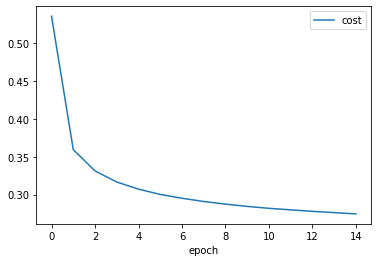

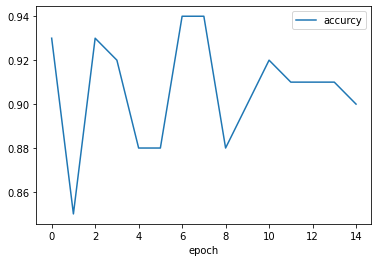

In [6]:

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
total_batch = len(data_loader)
mu.log("total_batch", total_batch)
mu.plt_init()

for epoch in range(traning_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        avg_cost += cost / total_batch

    accuracy = mu.get_cross_entropy_accuracy(hypothesis, Y)
    mu.log_epoch(epoch, traning_epochs, avg_cost, accuracy)

mu.plt_show()



--- 
 학습은 끝나고, 
 평가데이타를 이용하여 정확도 평가 


In [7]:

with torch.no_grad():
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)
    prediction = model(X_test)
    accuracy = mu.get_cross_entropy_accuracy(prediction, Y_test)
    mu.log("accuracy", accuracy)



accuracy : 0.8863


/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


--- 
 무작위로 5개의 데이타만 선택해서 이미지를 출력하면서 화면으로 확인해 봄. 


--------------------------------------------------------------------------------
r : 3757
X_single_data.shape : torch.Size([1, 784])

Y_single_data : 
    torch.Size([1]) tensor([8])

single_prediction : 
    torch.Size([1, 10]) tensor([[ -522.8351,   341.9146,   416.3286,  1050.5326,  -618.2287,  -305.8233,
             -1141.5387 ...

single_prediction_res : 3


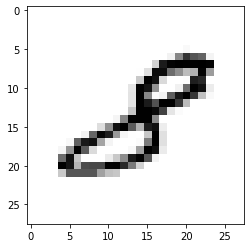

--------------------------------------------------------------------------------
r : 7304
X_single_data.shape : torch.Size([1, 784])

Y_single_data : 
    torch.Size([1]) tensor([5])

single_prediction : 
    torch.Size([1, 10]) tensor([[ 7.8717e+01,  7.8787e-01, -4.7460e+01,  1.4906e+03, -1.7955e+03,
              1.0965e+03,  1.5 ...

single_prediction_res : 3


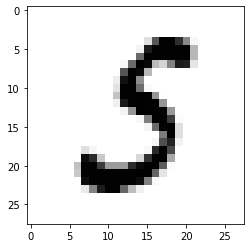

--------------------------------------------------------------------------------
r : 7300
X_single_data.shape : torch.Size([1, 784])

Y_single_data : 
    torch.Size([1]) tensor([7])

single_prediction : 
    torch.Size([1, 10]) tensor([[   49.4661, -2223.2407, -1341.2944,   440.9692,  -144.3791,    18.7647,
             -2174.0474 ...

single_prediction_res : 7


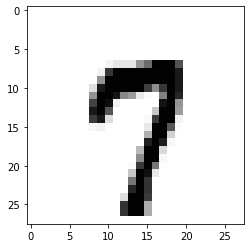

--------------------------------------------------------------------------------
r : 6039
X_single_data.shape : torch.Size([1, 784])

Y_single_data : 
    torch.Size([1]) tensor([9])

single_prediction : 
    torch.Size([1, 10]) tensor([[-1714.9358,  -239.3423,  -784.4327,   489.2284,   817.8240,   -69.3186,
             -1087.9860 ...

single_prediction_res : 9


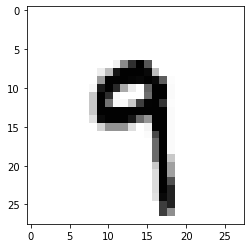

--------------------------------------------------------------------------------
r : 9429
X_single_data.shape : torch.Size([1, 784])

Y_single_data : 
    torch.Size([1]) tensor([3])

single_prediction : 
    torch.Size([1, 10]) tensor([[ -880.2283, -1532.4091,   628.1683,  2202.3574,  -457.8350,   484.4172,
             -1265.1261 ...

single_prediction_res : 3


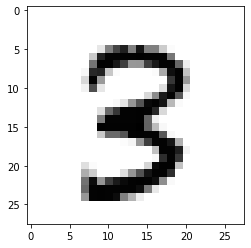

In [8]:

for _ in range(5):
    print("-" * 80)
    r = random.randint(0, len(mnist_test) - 1)
    mu.log("r", r)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    mu.log("X_single_data.shape", X_single_data.shape)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)
    mu.log("Y_single_data", Y_single_data)
    single_prediction = model(X_single_data)
    mu.log("single_prediction", single_prediction)
    single_prediction_res = torch.argmax(single_prediction, 1).item()
    mu.log("single_prediction_res", single_prediction_res)
    mu.plt_img_show(mnist_test.test_data[r:r + 1], 28, 28)
